## Load Modules

In [1]:
import numpy as np
import pandas as pd
from rtree import index
from collections import deque
from queue import PriorityQueue
import math
import time

# Status
UNKNOWN = -1
NOISE = -2

class DataLoader(object):
    @staticmethod
    def load_data_label(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ... , label) in each line
        """
        with open(path, 'r') as f:
            data = []
            label = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source[:-1]])
                label.append(int(source[-1]))
            return np.array(data), np.array(label)

    @staticmethod
    def load_data(path: str):
        """
        this is for input file with (coordinate_x, coordinate_y, ...) in each line
        """
        with open(path, 'r') as f:
            data = []
            for l in f.readlines():
                source = l.strip().split()
                data.append([float(val) for val in source])
            return np.array(data)

        
class Evaluation(object):
    @classmethod
    def silhouette_coefficient(cls, dbscan_obj):
        def a(pid, tags, dist_matrix):
            mask = tags == tags[pid]
            avg_dist = np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask)
            return avg_dist

        def b(pid, tags, dist_matrix):
            avg_dists = []
            for label in range(1,
                               max(tags) + 1):  # cluster label starts from 1
                if label == tags[pid]:
                    continue
                mask = tags == label
                avg_dists.append(
                    np.sum(dist_matrix[pid] * mask, axis=0) / np.sum(mask))
            return min(avg_dists)

        # preparation
        # if sum(dbscan_obj.tags) == -dbscan_obj.num_p:
        if sum(dbscan_obj.tags) < 0:
            raise Exception(f'eps:{dbscan_obj.eps} and min_pts:{dbscan_obj.min_pts} can cluter dataset well!')
            
        if not hasattr(dbscan_obj, 'dist_m'):
            # by default, we try to use matrix dbscan to tune parameters
            # BUG: If use basic dbscan has no _get_distance_matrix() attribute function
            dbscan_obj._get_distance_matrix()
        tags = np.array(dbscan_obj.tags)

        # TODO: this method still can be optimised by matrix computation
        res = 0
        for pid in range(dbscan_obj.num_p):
            tmp_a = a(pid, tags, dbscan_obj.dist_m)
            tmp_b = b(pid, tags, dbscan_obj.dist_m)
            res += (tmp_b - tmp_a) / max(tmp_b, tmp_a)
        res /= dbscan_obj.num_p

        print(
            f'eps: {dbscan_obj.eps} min points: {dbscan_obj.min_pts} silhouette coefficient: {res}'
        )
        return res

def timeit(func):
    def wrapper(*args, **wargs):
        start = time.time()
        res = func(*args, **wargs)
        end = time.time()
        print(f'{func.__name__} time cost: {(end-start)*1000}ms')
        return res    
    return wrapper


##  DBSCAN Module

In [2]:
class DBSCAN(object):
    """
    Base Class of DBSCAN, please do NOT instantiate this Class
    """

    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        """
        :param: dataset: numpy array or numpy matrix; set of data point coordinates 
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        :param: metric: str; the distance metric: (euclidian, manhattan, fast-euclidian)
        """
        self.m, _ = (dataset, None
                     )  # placeholder _ for future implementation of labels
        self.num_p = self.m.shape[0]
        self.tags = [UNKNOWN] * self.num_p
        self.is_core = [0] * self.num_p

        self.eps = eps**2 if metric == 'fast-euclidian' else eps
        self.min_pts = min_pts
        self.metric = metric

    def _get_dist(self, a, b) -> float:
        """
        for float comparison, set all distance value precision to 5
        :param: a: int; index of given point in data matrix
        :param: b: same as a
        """
        if self.metric == 'euclidian':
            result = np.sqrt(np.power(self.m[b] - self.m[a], 2).sum())
        elif self.metric == 'manhattan':
            result = np.abs(self.m[b] - self.m[a]).sum()
        elif self.metric == 'fast-euclidian':
            result = np.power(self.m[b] - self.m[a], 2).sum()
        else:
            raise Exception(f'Distance metric {self.metric} is invalid!')

        return round(result, 5)

    def _get_neighbours(self, p: int) -> list:
        """
        return neighbours index of given point p in source data matrix
        :param: p: int; index of given point in data matrix
        """
        pass

    def _clustering(self, p, cluster_id):
        """
        tag given point p and all of its neighbours and sub-neighbours with the same cluster id
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: cluster_id: int; current id of cluster
        """
        pass

    def _find_core_pts(self):
        self.is_core = [0] * self.num_p
        for i in range(self.num_p):
            if len(self._get_neighbours(i)) > self.min_pts:
                self.is_core[i] = 1
        return self.is_core

    @timeit
    def predict(self) -> list:
        """
        return list of labels as the sequence in data matrix
        :param: m: np.matrix; N * 2 matrix recoding all nodes' coordinates
        :param: eps: float; the value of radius of density area
        :param: min_pts: int; least neighbours should be in a density area
        """

        cluster_id = 1
        for p_id in range(self.num_p):
            if self.tags[p_id] != UNKNOWN:
                continue
            if self._clustering(p_id, cluster_id):
                cluster_id += 1
        return np.array(self.tags)


class NaiveDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(NaiveDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_neighbours(self, p: int) -> list:

        ngbs = []
        for idx in range(len(self.m)):
            if self._get_dist(p, idx) < self.eps:
                ngbs.append(idx)
        return ngbs

    def _clustering(self, p, cluster_id) -> bool:

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True


class MatrixDBSCAN(DBSCAN):
    def __init__(self, dataset, eps, min_pts, metric='euclidian'):
        super(MatrixDBSCAN, self).__init__(dataset, eps, min_pts, metric)

    def _get_distance_matrix(self):
        """
        Only once calculation will be on each point-pairs
        results will be stored in self.dist_m
        """
        self.dist_m = np.zeros((self.num_p, self.num_p))
        for p_id in range(self.num_p):
            for q_id in range(p_id, self.num_p):
                dist = self._get_dist(p_id, q_id)
                self.dist_m[q_id, p_id] = dist
                self.dist_m[p_id, q_id] = dist

    def _get_neighbours(self, p: int) -> list:
        if not hasattr(self, 'dist_m'):                #判断里面是否有‘dist_m'
            self._get_distance_matrix()
        return np.nonzero(self.dist_m[p] < self.eps)[0] #判断有多少个dist 小于eps

    def _clustering(self, p, cluster_id) -> bool:
        """
        TODO: There should be some optimizations for this part, current code is too ugly
        """

        neighbours = self._get_neighbours(p)
        if len(neighbours) < self.min_pts:
            self.tags[p] = NOISE
            return False
        else:
            self.tags[p] = cluster_id
            for idx in neighbours:
                self.tags[idx] = cluster_id
            while len(neighbours) > 0:
                sub_neighbours = self._get_neighbours(neighbours[0])
                if len(sub_neighbours) >= self.min_pts:
                    for sub_n in sub_neighbours:
                        if self.tags[sub_n] < 0:
                            self.tags[sub_n] = cluster_id
                            if self.tags[sub_n] == UNKNOWN:
                                neighbours.append(sub_n)
                neighbours = neighbours[1:]
        return True

## 2. Parallel Implementation

In [3]:
from pyspark import SparkContext
SparkContext.getOrCreate()
SparkContext

pyspark.context.SparkContext

###  General DBSCAN

In [4]:
def load_data_label(path):
#Strip () is used to remove the preceding space, and then take the last column as the label
#Change each x element to a float tuple and save it
    pts = sc.textFile(path).map(lambda x: x.strip().split()[:-1]).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def load_data(path):
#Strip () is used to remove the preceding space, and then take all the columns as the dataset
#Change each x element to a float tuple and save it
    pts = sc.textFile(path).map(lambda x: x.strip().split()).map(lambda x: tuple([float(i) for i in x]))
    return pts.collect()

def _bounds_coordinates(bin_bounds):

    lower_cdnts = [[low] for low in  bin_bounds[0][:-1]]
    upper_cdnts = [[high] for high in bin_bounds[0][1:]]
    
    # super stupid implementation, optimization needed
    for bound in bin_bounds[1:]:
        lower_tmp = []
        upper_tmp = []
        
        for bc in bound[:-1]:
            lower_tmp.extend([lc + [bc] for lc in lower_cdnts])
        lower_cdnts = lower_tmp
        
        for bc in bound[1:]:
            upper_tmp.extend([uc + [bc] for uc in upper_cdnts])
        upper_cdnts = upper_tmp
        
    return np.array(lower_cdnts), np.array(upper_cdnts)

@timeit
def spatial_partition(dataset, n_partitions, eps):
    """
    n_partitions: tuple with shape correspoding to dataset dimension
    """
    tp_par = n_partitions
    num_par = np.prod(n_partitions)  # prod(2，2)= 2*2 = 4个partition
    
    # cut bins
    bounds = np.concatenate(([np.min(dataset, axis=0)], [np.max(dataset, axis=0)]), axis=0)     # 2 * D
    bounds_dim = bounds.T   # D * 2, 
    print("tp_par:" + tp_par)
    print("bounds_dim:" + bounds_dim)
    
    bin_bounds = []
    for i in range(len(tp_par)):
        dim_bins = np.linspace(*bounds_dim[i], tp_par[i]+1, endpoint=True)
        bin_bounds.append(dim_bins)
    print("bin_bounds:" + bin_bounds)
    
    lower_bounds, upper_bounds = _bounds_coordinates(bin_bounds)
    lower_bounds -= eps
    upper_bounds += eps

    # scatter points into bins with eps
    indexed_data = []
    for id_pts in range(len(dataset)):     # index of point in dataset
        for id_ptt in range(num_par):
            if not (dataset[id_pts] > lower_bounds[id_ptt]).all():
                continue
            if not (dataset[id_pts] < upper_bounds[id_ptt]).all():
                continue
            indexed_data.append([id_ptt, id_pts])
            
    res = sc.parallelize(indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res

def local_dbscan(partioned_rdd, method='matrix', metric='euclidian'):

    dataset = np.array([b_dataset.value[idp] for idp in partioned_rdd])
    if method == 'matrix':
        dbscan_obj = MatrixDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    else:
        dbscan_obj = NaiveDBSCAN(dataset, b_eps.value, b_min_pts.value, metric) 
    dbscan_obj.predict()
    is_core_list = dbscan_obj._find_core_pts()
    
    return list(zip(zip(partioned_rdd, is_core_list), dbscan_obj.tags))

@timeit
def merge(local_tags, dataset):
    global_tags = [UNKNOWN] * len(dataset)
    is_tagged = [0] * len(dataset)
    last_max_label = 0
    for local in local_tags:
        np_local = np.array(local[-1])
        np_local[:, -1] += last_max_label

        last_max_label = np.max(np_local[:, -1])
        
        # check and merge overlapped points
        tagged_indices = np.nonzero(is_tagged)[0]
        for tmp_i in range(len(np_local)):
            # should do tag check
            (p_id, is_core), label = np_local[tmp_i]
            if p_id in tagged_indices and is_core==1:
                np_local[-1][np_local[-1]==label] = global_tags[p_id]
        
        # update global tags
        for (p_id, is_core), label in np_local:
            if is_tagged[p_id]==1:
                continue
            global_tags[p_id] = label
            is_tagged[p_id] = 1
    return global_tags

In [5]:
len((2,2))

2

###  RTree-based on boundry

In [20]:
def _get_cost(bounds, nPoints, fanout=2):
    h = math.log((nPoints + 1) / fanout, fanout) + 1
    DA = h + math.sqrt(nPoints) * 2 / (math.sqrt(fanout) -
                                       1) + nPoints / (fanout - 1) + 1
    return DA * nPoints

def reduced_boundary_partition(rtree, maxPoints, eps):
    mbr = rtree.bounds
    partition_list = []
    queue = deque()       
    #Create queue: queue
    queue.append(mbr)     
    #In the right side of the queue, add the minimum limited matrix of MBR
    while len(queue):     
        br = queue.popleft()   
        #获取最左边一个元素也就是第一个mbr=br，并在队列queue中删除
        nPoints = rtree.count(br) 
        #Get the leftmost element, that is, the first MBR = BR, and delete it in the queue queue 
        if nPoints > maxPoints:   
        #The number of sample points in the first MBR > the maximum number
            (br1, br2) = _reduced_boundary_split(rtree, br, eps)
            queue.append(br1)
            queue.append(br2)
        else:
            partition_list.append(br)
    return partition_list



def _reduced_boundary_split(rtree, br, eps):

    (xmin, ymin, xmax, ymax) = br           

    #vertical splitline candidates
    ymin_score = float('inf')               #Initialize to positive infinity
    ysplit = ymin + (ymax - ymin) / 2       #Middle of y value
    ybest_split = ((xmin, ymin, xmax, ysplit), (xmin, ysplit, xmax, ymax))  #The first time is to divide the vertical axis into two and a half
    while (ysplit + eps * 2 <= ymax):       
        br1 = (xmin, ymin, xmax, ysplit)    
        br2 = (xmin, ysplit, xmax, ymax)    #Bisect the br rectangle on the vertical axis
        point_diff = abs(rtree.count(br1) - rtree.count(br2)) #The difference of the number of sample points contained in the upper and lower bisection rectangle
        score = point_diff * rtree.count((xmin, ysplit - eps, xmax, ysplit + eps))
                                            
        if score < ymin_score:              
            ymin_score = score              
            ybest_split = (br1, br2)        
            if rtree.count(br1) > rtree.count(br2):   
                ysplit = ymin + (ysplit - ymin) / 2  
            else:
                ysplit = ysplit + (ymax - ysplit) / 2
        else:
            break

    #horizontal splitline candidates
    xsplit = xmin + eps * 2
    xmin_score = float('inf')
    xbest_split = ((xmin, ymin, xsplit, ymax), (xsplit, ymin, xmax, ymax))
    while (xsplit + eps * 2 <= xmax):
        br1 = (xmin, ymin, xsplit, ymax)
        br2 = (xsplit, ymin, xmax, ymax)
        point_diff = abs(rtree.count(br1) - rtree.count(br2))
        score = point_diff * rtree.count((xmin - eps, ymin, xmin + eps, ymax))
        if score < xmin_score:
            xmin_score = score
            xbest_split = (br1, br2)
            if rtree.count(br1) > rtree.count(br2):
                xsplit = xmin + (xsplit - xmin) / 2
            else:
                xsplit = xsplit + (xmax - xsplit) / 2
        else:
            break

    if xmin_score < ymin_score:
        return xbest_split
    else:
        return ybest_split


#construct rtree index
def construct_rtree_index(dataset):
    p = index.Property()
    rtree_idx = index.Index(properties=p)
    count = 0
    for coordinate in dataset:
        rtree_idx.insert(count, (*coordinate, *coordinate))
        count += 1
    return rtree_idx


def rbs_fixnum(rtree, eps, n_partition):
    mbr = rtree.bounds
    partition_list = []
    queue = PriorityQueue()
    queue.put((-rtree.count(mbr), mbr))
    while queue.qsize() < n_partition:
        (score, br) = queue.get()
        subbrs = _reduced_boundary_split(rtree, br, eps)
        for subbr in subbrs:

            queue.put((-rtree.count(subbr), subbr))
    while queue.qsize() > 0:
        (score, br) = queue.get()
        partition_list.append(br)
    return partition_list


@timeit
def rtree_partition(dataset, n_patitions, eps, mtd='rbs'):
    """
    params:parameters needed for different spliting method; for cost-base method params=('cbs', max_cost);
    for reduced-boundary method params = ('rbs', max_points)
    """
    idx = construct_rtree_index(dataset)
    
    # #split test
    if mtd == 'cbs':
        partitioned = cbs_fixnum(idx, eps, n_patitions)
    else:
        partitioned = rbs_fixnum(idx, eps, n_patitions)

    indexed_data = []
    id_ptt = 0
    for boundary in partitioned:
        (left, bot, right, top) = boundary
        for id_pts in idx.intersection((left - eps, bot - eps, right + eps, top + eps)):    
#找出与(left - eps, bot - eps, right + eps, top + eps)有公共区域的所有的区域;计算这些点有已经存在的点的交点
            indexed_data.append([id_ptt, id_pts])
        id_ptt += 1

    res = sc.parallelize(
        indexed_data).groupByKey().map(lambda x: [x[0], list(x[1])])
    return res


###  Entry Functions

In [21]:
def partition(dataset, eps, partition_tuple, rtree=False, rtree_mtd='cbs'):
    if rtree:
        partition_tuple = np.prod(partition_tuple)
        partitioned_rdd = rtree_partition(dataset,
                                          partition_tuple,
                                          eps,
                                          mtd=rtree_mtd)
    else:
        partitioned_rdd = spatial_partition(dataset, partition_tuple, eps)
    return partitioned_rdd


# parallel entry function
@timeit
def parallel_dbscan(dataset,
                    eps,
                    min_pts,
                    partition_tuple,
                    method='matrix',
                    metric='euclidian',
                    rtree=False,
                    rtree_mtd='cbs',
                    verbose=False):

    #     b_dataset = sc.broadcast(dataset)
    #     b_eps = sc.broadcast(eps)
    #     b_min_pts = sc.broadcast(min_pts)
    partitioned_rdd = partition(dataset,
                                eps,
                                partition_tuple,
                                rtree=rtree,
                                rtree_mtd=rtree_mtd)
    local_tags = partitioned_rdd.mapValues(lambda x: local_dbscan(
        x, method=method, metric=metric)).collect()
    result_tags = merge(local_tags, dataset)
    
    if verbose:
        p = partitioned_rdd.collect()
        print('Partition info:')
        for i in range(len(p)):
            print('partition ', p[i][0],
                  ', num of points: ', len(p[i][1]),
                  ', num of clusters: ', len(np.unique(np.array(local_tags[i][-1])[:, 1])))
        print('Number of Clusters:')

    return result_tags


##  Plot Module

In [22]:
%matplotlib notebook


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib notebook

def plot_result(dataset, result_tags, file_name=None, style='ticks'):
    # data preparation
    dataset = np.array(dataset)
    df = pd.DataFrame()
    df['x'] = dataset[:, 0]
    df['y'] = dataset[:, 1]
    df['label'] = result_tags
    
    # sns preparation
#     sns.set_context("notebook", font_scale=1)
    sns.set_style(style)
    f, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    
    sns.scatterplot('x', 'y',data=df, ax=axes[0], palette='Blues_d')
    sns.scatterplot('x', 'y', data=df, hue='label', ax=axes[1])
    
    plt.title(f'DBSCAN Result of {file_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    
#     plt.legend(loc='upper right')
    plt.gca().get_legend().set_visible(False)

    plt.tight_layout()
    plt.show()

##  Test Playground

In [24]:
test_file = '../2.dataset/jain.txt'
dataset = np.array(load_data_label(test_file))
n_partitions = (4, 2)
eps = 2
min_pts = 18

mdbscan = MatrixDBSCAN(dataset, eps, min_pts)
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)
del mdbscan
#plot_result(dataset, result_tags, 'Jain')

predict time cost: 836.3692760467529ms
eps: 2 min points: 18 silhouette coefficient: 0.29942766374570623


###  spiral_312

In [44]:
test_file = '../2.dataset/spiral.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [[2, 2], [2, 4], [2, 5]]
#n_partition_set = [[2, 2]]
eps = 3.5
min_pts = 2
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',
                                 rtree=True, rtree_mtd='rbs')


SERIAL:
predict time cost: 1148.3073234558105ms

SERIAL:
predict time cost: 558.3422183990479ms
eps: 3.5 min points: 2 silhouette coefficient: 0.4661964889068999

Partitions: 4

Rtree-rbs:
rtree_partition time cost: 23.150205612182617ms
merge time cost: 5.506038665771484ms
parallel_dbscan time cost: 296.4341640472412ms

Partitions: 8

Rtree-rbs:
rtree_partition time cost: 29.851198196411133ms
merge time cost: 6.851911544799805ms
parallel_dbscan time cost: 291.0909652709961ms

Partitions: 10

Rtree-rbs:
rtree_partition time cost: 27.36210823059082ms
merge time cost: 6.184101104736328ms
parallel_dbscan time cost: 332.3779106140137ms


predict time cost: 574.6269226074219ms


<IPython.core.display.Javascript object>


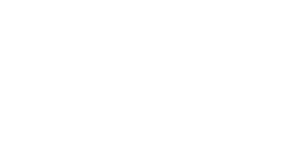

eps: 3.5 min points: 2 silhouette coefficient: 0.4661964889068999


0.4661964889068999

In [46]:
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
plot_result(dataset, result_tags, 'Spiral')
Evaluation.silhouette_coefficient(mdbscan)

### agg_788

In [41]:
test_file = '../2.dataset/aggregation.txt'
dataset = np.array(load_data_label(test_file))
n_partition_set = [(2, 2), [2, 4], [2, 5]]
# n_partition_set = [[2, 4], [4, 4], [4,8]]
eps = 2.2
min_pts = 23
b_dataset = sc.broadcast(dataset)
b_eps = sc.broadcast(eps)
b_min_pts = sc.broadcast(min_pts)

In [42]:
# serial naive
print('\nSERIAL:')
mdbscan = NaiveDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()

print('\nSERIAL:')
mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
Evaluation.silhouette_coefficient(mdbscan)

for n_partitions in n_partition_set:
    print(f'\nPartitions: {np.prod(n_partitions)}')
    print('\nRtree-rbs:')
    result_tags = parallel_dbscan(dataset, eps, min_pts, n_partitions, method='matrix', metric='fast-euclidian',rtree=True, rtree_mtd='rbs')

    


SERIAL:
predict time cost: 6399.1851806640625ms

SERIAL:
predict time cost: 3575.4528045654297ms
eps: 2.2 min points: 23 silhouette coefficient: 0.3278009890155017

Partitions: 4

Rtree-rbs:
rtree_partition time cost: 42.84811019897461ms
merge time cost: 5.11622428894043ms
parallel_dbscan time cost: 792.288064956665ms

Partitions: 8

Rtree-rbs:
rtree_partition time cost: 49.09181594848633ms
merge time cost: 8.744001388549805ms
parallel_dbscan time cost: 504.11176681518555ms

Partitions: 10

Rtree-rbs:
rtree_partition time cost: 46.50998115539551ms
merge time cost: 8.392810821533203ms
parallel_dbscan time cost: 555.6399822235107ms


predict time cost: 3583.1191539764404ms
Number of clusters: 16
eps: 3 min points: 34 silhouette coefficient: 0.37706102254990087


<IPython.core.display.Javascript object>


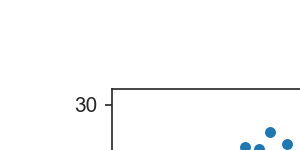

In [43]:
eps = 3
min_pts = 34

mdbscan = MatrixDBSCAN(dataset, eps, min_pts, metric='euclidian')
result_tags = mdbscan.predict()
print('Number of clusters:', len(np.unique(np.array(result_tags))))
Evaluation.silhouette_coefficient(mdbscan)
plot_result(dataset, result_tags, 'Aggregation_778')